In [163]:
import hdbscan
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [164]:
data = pd.read_excel("data.xlsx", index_col=0)

def parse_input(data):
    
    #rename dataframes and apply correct unit measurement
    data.rename(columns = {"Pressure (Bar)":"Pressure", "Temperature (K)":"Temperature"}, inplace=True)
    data["Phi"]=data["Phi"].apply(ast.literal_eval)
    data["Temperature"]=data["Temperature"].apply(ast.literal_eval)
    data["Temperature Symbol"] = "K"
    data["Pressure"]=data["Pressure"].apply(ast.literal_eval)
    data["Pressure Symbol"] = "Bar"
    
    #split tuples into columns
    names=["Phi0", "Phi1"]
    for index,column in enumerate(names):
        data[column] = data['Phi'].apply(lambda Phi: Phi[index])
    names=["T0", "T1"]
    for index,column in enumerate(names):
        data[column] = data['Temperature'].apply(lambda Temperature: Temperature[index])
    names=["P0", "P1"]
    for index,column in enumerate(names):
        data[column] = data['Pressure'].apply(lambda Pressure: Pressure[index])
    
    return data

data=parse_input(data)
data.head()

Experiment DOI  Exp SciExpeM ID              Chem Model  \
0      10.24388/x10001073             1303  CRECK_2100_PAH_2110_AN   
1  10.5281/zenodo.5055391              853  CRECK_2100_PAH_2110_AN   
2  10.5281/zenodo.5140956             1023  CRECK_2100_PAH_2110_AN   
3      10.24388/x10001072             1276  CRECK_2100_PAH_2110_AN   
4  10.5281/zenodo.4882058              465  CRECK_2100_PAH_2110_AN   

   Chem Model ID                       Experiment Type          Reactor  \
0             24            ignition delay measurement       shock tube   
1             24      outlet concentration measurement     flow reactor   
2             24  laminar burning velocity measurement            flame   
3             24            ignition delay measurement       shock tube   
4             24       jet stirred reactor measurement  stirred reactor   

          Target         Fuels             Phi        Pressure  \
0  tau_OH(slope)  ['H2', 'CO']    (0.66, 0.66)    (30.2, 32.3)   
1        CH3OH_x       ['CH4']    (98.8, 98.8)  (100.0, 100.0)   
2          Speed        ['H2']      (0.8, 3.8)      (1.0, 1.0)   
3  tau_OH(slope)  ['H2', 'CO']  (0.655, 0.655)    (11.0, 13.0)   
4         C7H8_x  ['C10H7CH3']      (1.0, 1.0)    (10.0, 10.0)   

        Temperature     Score     Error      d0L2      d1L2      d0Pe  \
0  (1161.0, 1329.0)  0.801604  0.008321  0.785664  0.503717  0.927103   
1    (598.0, 850.0)  0.870905  0.000645  0.957619  0.962123  0.752544   
2    (363.0, 363.0)  0.905585  0.005129  0.896478  0.860606  0.919203   
3  (1116.0, 1388.0)  0.809289  0.006391  0.778666  0.578798  0.902491   
4   (800.0, 1150.0)  0.892126  0.001222  0.892754  0.910631  0.922645   

       d1Pe     shift Temperature Symbol Pressure Symbol    Phi0    Phi1  \
0  0.748017  0.922562                  K             Bar   0.660   0.660   
1  0.835408  0.858867                  K             Bar  98.800  98.800   
2  0.826403  0.965410                  K             Bar   0.800   3.800   
3  0.743595  0.926093                  K             Bar   0.655   0.655   
4  0.784453  0.921138                  K             Bar   1.000   1.000   

       T0      T1     P0     P1  
0  1161.0  1329.0   30.2   32.3  
1   598.0   850.0  100.0  100.0  
2   363.0   363.0    1.0    1.0  
3  1116.0  1388.0   11.0   13.0  
4   800.0  1150.0   10.0   10.0

In [165]:
##############################################################
# COMPUTE DATA NOT GROUPED 
##############################################################

In [166]:
#comment the columns that u dont want to be in hdbscan
columns = [ 
            # "Experiment DOI",
            # "Exp SciExpeM ID",
            # "Chem Model",
            # "Chem Model ID",
            # "Experiment Type",
            # "Reactor",
            # "Target",
            # "Fuels",
            # "Phi",
            "Phi0",
            "Phi1",
            # "Pressure",
            "P0",
            "P1",
            # "Temperature",
            "T0",
            "T1",
            "Score",
            "Error",
            "d0L2",
            "d1L2",
            "d0Pe",
            "d1Pe",
            "shift"
            ]


In [167]:
# returns the HDBSCAN cluster object fitted with data and a dictionary containing run evaluation
def hdbscanned(input_data, iterations = 1):
    best_min_cluster = {"n_cluster":0, "probability":0, "n_noise":input_data.shape[0], "best_metrics":"euclidean"}
    for iteration in range(iterations):
        for metrics in hdbscan.dist_metrics.METRIC_MAPPING.keys():
            for i in range(2,min(100,input_data.shape[0])):
                clusterer = hdbscan.HDBSCAN(min_cluster_size=i)
                clusterer = clusterer.fit(input_data)
                if clusterer.probabilities_[clusterer.probabilities_==0].shape[0]<=best_min_cluster["n_noise"]:
                    if clusterer.probabilities_[clusterer.probabilities_>0].mean() > best_min_cluster["probability"]:
                        best_min_cluster["n_cluster"] = i
                        best_min_cluster["probability"] = clusterer.probabilities_[clusterer.probabilities_>0].mean()
                        best_min_cluster["n_noise"] = clusterer.probabilities_[clusterer.probabilities_==0].shape[0]
                        if metrics != best_min_cluster["best_metrics"]:
                            best_min_cluster["best_metrics"] = metrics

    print(f"best_min_cluster = {best_min_cluster}\n")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster["n_cluster"],metric=best_min_cluster["best_metrics"])
    return clusterer.fit(input_data),best_min_cluster 

# running hdbscan and placing results into data
clusterer, clusterer_eval = hdbscanned(data.loc[:,columns])
data["ClusterID"] = clusterer.labels_
data.to_excel("clustered.xlsx")
# data.head()

best_min_cluster = {'n_cluster': 2, 'probability': 0.7937691446357324, 'n_noise': 111, 'best_metrics': 'euclidean'}



In [1]:
data = pd.read_excel("clustered.xlsx", index_col=0)

# performs descriptive analysis on clustered data 
def groupanddescribe(data, groupby_elem = ["ClusterID"],  slc = ["Phi0"], statistics = {"mean":pd.core.groupby.GroupBy.mean}, count=False):
    #init empty dataframe
    retval = pd.DataFrame()
    if count:
        statistics["count"]=pd.core.groupby.GroupBy.count
    
    for stat_name, stat in statistics.items():

        grouped = data.groupby(groupby_elem)[slc]
        grouped = stat(grouped)
        m_index = pd.MultiIndex.from_tuples([(x,stat_name) for x in grouped.keys()])
        grouped.columns=m_index
        retval = pd.concat([retval, grouped], axis = 1)
        
    if "count" in list(zip(*retval.keys()))[1]:
        #drop all column with count except the first one
        count_columns = [i for i in retval.keys() if i[1]=="count"]
        retval = retval.drop(columns = count_columns[1:])
        renamed_index = list(retval.keys())
        renamed_index[-1]=list(renamed_index[-1])
        renamed_index[-1][0]=""
        retval.columns = pd.MultiIndex.from_tuples(renamed_index)
    retval.columns = retval.columns.swaplevel()#.map('_'.join)    
    return retval

# change the stats you would like to see in stat_name if they are part of pandas.core.groupby.GroupBy.*
stat_names = ["mean", "min", "max", "median", "std", "var"]
stats = {stat_name:getattr(pd.core.groupby.GroupBy, stat_name) for stat_name in stat_names}
metadata = groupanddescribe(data, slc=columns, statistics = stats, count=True)
metadata.to_excel("metadata.xlsx")
metadata.to_csv("metadata.csv")

# set option to print all the columns
pd.set_option('display.max_columns', None)
metadata.head()

NameError: name 'pd' is not defined

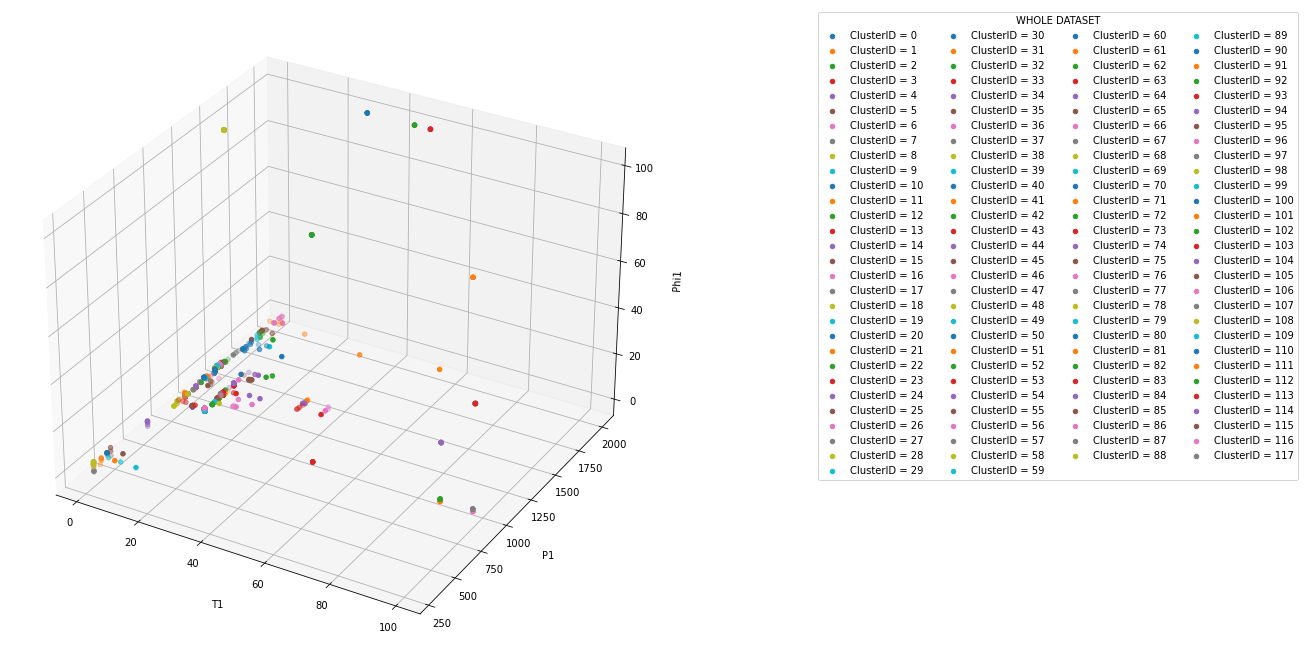

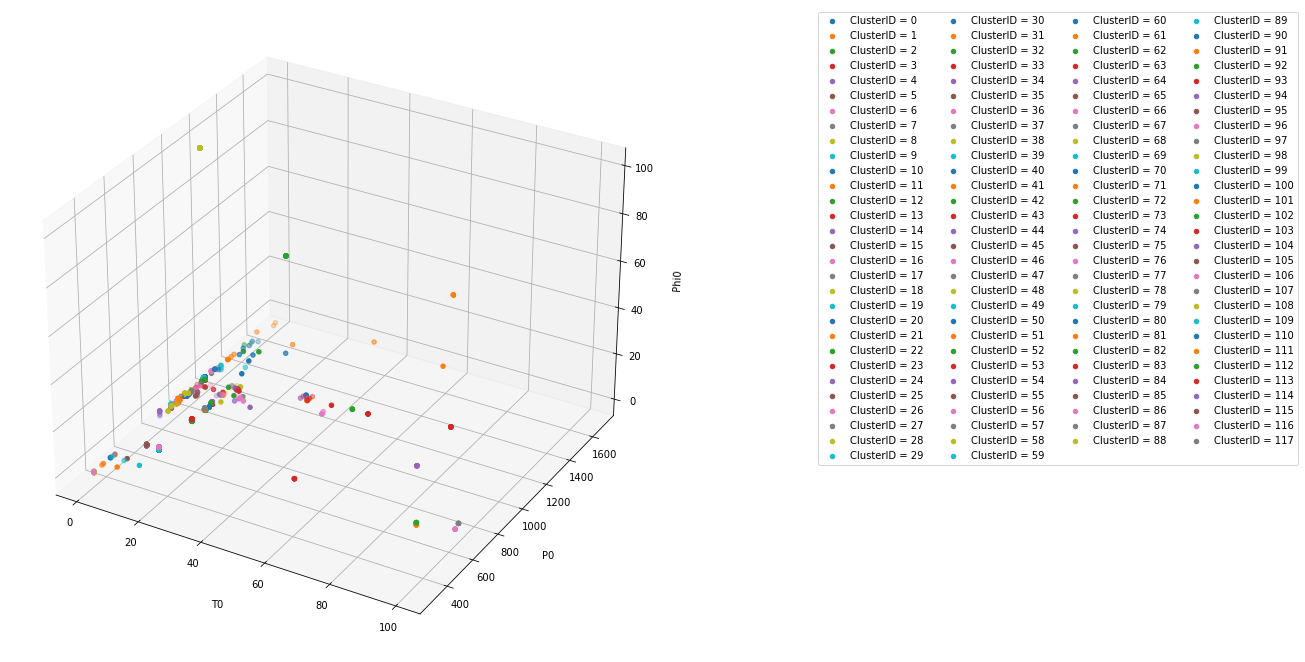

In [195]:
def graph_the_data_by_cluster(data, columns = [ 'T0','P0', 'Phi0'], ignore_noise = False, title = None):
    fig = plt.figure(figsize=(12, 9))
    ax = Axes3D(fig, auto_add_to_figure = False)
    
    if ignore_noise:
        data = data.loc[data["ClusterID"]!=-1,:]
    
    grouped = data.groupby('ClusterID').groups.items()
    for grp_name, grp_idx in grouped:
        y = data.loc[grp_idx,columns[0]]
        x = data.loc[grp_idx,columns[1]]
        z = data.loc[grp_idx,columns[2]]
        ax.scatter(x,y,z, label="ClusterID = "+str(grp_name), cmap='coolwarm')  # this way you can control color/marker/size of each group freely
        #ax.scatter(*data.loc[grp_idx, [columns[0], columns[2], columns[4]]].T.values, label=grp_name)  # if you want to do everything in one line, lol
    ax.set_xlabel('\n' + columns[0], linespacing=4)
    ax.set_ylabel('\n' + columns[1], linespacing=4)
    ax.set_zlabel('\n' + columns[2], linespacing=4)

    ax.legend(ncol=4, bbox_to_anchor=(2, 1), loc='upper right', title=title)
    fig.add_axes(ax)
    return

graph_the_data_by_cluster(data, ['T1','P1', 'Phi1'], ignore_noise=True, title = "WHOLE DATASET")
graph_the_data_by_cluster(data, ignore_noise=True)
    

In [ ]:
##############################################################
# COMPUTE DATA GROUPEDBY
##############################################################

In [168]:
#comment the columns that u dont want to be in hdbscan

columns = [ 
            # "Experiment DOI",
            # "Exp SciExpeM ID",
            # "Chem Model",
            # "Chem Model ID",
            # "Experiment Type",
            # "Reactor",
            # "Target",
            # "Fuels",
            # "Phi",
            "Phi0",
            "Phi1",
            # "Pressure",
            "P0",
            "P1",
            # "Temperature",
            "T0",
            "T1",
            "Score",
            "Error",
            "d0L2",
            "d1L2",
            "d0Pe",
            "d1Pe",
            "shift"
            ]

group_by = [
            # "Experiment DOI",
            # "Exp SciExpeM ID",
            # "Chem Model",
            # "Chem Model ID",
            # "Experiment Type",
            # "Reactor",
             "Target",
            # "Fuels",
            # "Phi",
            # "Phi0",
            # "Phi1",
            # "Pressure",
            # "P0",
            # "P1",
            # "Temperature",
            # "T0",
            #"T1",
            # "Score",
            # "Error",
            # "d0L2",
            # "d1L2",
            # "d0Pe",
            # "d1Pe",
            # "shift"
            ]

In [188]:
ignored = []
clustered_groups = []
for group in parse_input(pd.read_excel("data.xlsx", index_col=0)).groupby(group_by):
    #group is a tuple(groupbyID, dataframe grouped)
    data = group[1]
    group_name = group[0]
    if data.shape[0]>20:
        print(f'GROUP:\t{group_name}')
        clusterer, clusterer_eval = hdbscanned(data.loc[:,columns])
        data["ClusterID"]=clusterer.labels_
        clustered_groups.append((group_name,data))
        
    else: ignored.append(group_name)
        
print(f"ignored values\n{ignored}")
groupanddescribe(clustered_groups[0][1], slc=columns, statistics = stats, count=True)



GROUP:	C2H2_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.8574292351257693, 'n_noise': 1, 'best_metrics': 'euclidean'}

GROUP:	C2H4_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.871059591554336, 'n_noise': 3, 'best_metrics': 'euclidean'}

GROUP:	C2H6_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.9229633607874819, 'n_noise': 0, 'best_metrics': 'euclidean'}

GROUP:	C6H6_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.8936216051979702, 'n_noise': 1, 'best_metrics': 'euclidean'}

GROUP:	CH2O_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.8597856116615734, 'n_noise': 2, 'best_metrics': 'euclidean'}

GROUP:	CH4_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.8175450392387338, 'n_noise': 4, 'best_metrics': 'euclidean'}

GROUP:	CO2_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.8688327433000501, 'n_noise': 8, 'best_metrics': 'euclidean'}

GROUP:	CO_x
best_min_cluster = {'n_cluster': 2, 'probability': 0.8664032033876369, 'n_noise': 11, 'b

mean                                                 \
                 Phi0        Phi1         P0         P1           T0   
ClusterID                                                              
-1         100.000000  100.000000   1.000000   1.000000  1100.000000   
 0           0.000000  100.000000  42.219000  42.219000  1200.000000   
 1           0.892857    0.892857   8.973571   8.973571   560.000000   
 2           0.666667    0.666667   1.000000   1.000000  1102.000000   
 3           1.000000    1.000000  10.133000  10.133000   800.000000   
 4           1.120000    1.120000   1.013000   1.013000  1121.000000   
 5           0.860000    0.860000   1.010400   1.010400   940.000000   
 6           0.563333    0.563333   6.866667   6.866667   931.666667   
 7           0.833333    0.833333   7.088667   7.088667   966.666667   

                                                                          \
                    T1     Score     Error      d0L2      d1L2      d0Pe   
ClusterID                                                                  
-1         1500.000000  0.853086  0.002149  0.949696  0.873040  0.783296   
 0         2000.000000  0.808203  0.004874  0.987159  0.981282  0.919330   
 1         1030.000000  0.895290  0.001132  0.985664  0.981610  0.912485   
 2         1102.000000  0.734930  0.003197  0.608518  0.482508  0.934620   
 3         1186.666667  0.906770  0.001041  0.973621  0.964339  0.907818   
 4         1377.400000  0.767940  0.002536  0.970729  0.969156  0.806848   
 5         1380.000000  0.907642  0.001277  0.981425  0.977290  0.921890   
 6         1217.666667  0.896418  0.001221  0.952889  0.968034  0.887045   
 7         1300.000000  0.899730  0.001271  0.983598  0.985298  0.889097   

                                  min                                          \
               d1Pe     shift    Phi0    Phi1      P0      P1      T0      T1   
ClusterID                                                                       
-1         0.807116  0.852683  100.00  100.00   1.000   1.000  1100.0  1500.0   
 0         0.712230  0.624608    0.00  100.00  30.398  30.398  1200.0  2000.0   
 1         0.784406  0.853787    0.25    0.25   6.080   6.080   560.0  1030.0   
 2         0.740899  0.821518    0.00    0.00   1.000   1.000  1102.0  1102.0   
 3         0.727559  0.933640    0.50    0.50  10.133  10.133   800.0  1160.0   
 4         0.669683  0.595613    0.50    0.50   1.013   1.013  1090.0  1290.0   
 5         0.836609  0.864318    0.30    0.30   1.000   1.000   900.0  1375.0   
 6         0.794925  0.887808    0.19    0.19   0.467   0.467   900.0  1200.0   
 7         0.864840  0.837774    0.50    0.50   1.000   1.000   950.0  1300.0   

                                                                       \
              Score     Error      d0L2      d1L2      d0Pe      d1Pe   
ClusterID                                                               
-1         0.853086  0.002149  0.949696  0.873040  0.783296  0.807116   
 0         0.728821  0.000637  0.972858  0.974953  0.869463  0.597279   
 1         0.732628  0.000409  0.971968  0.970304  0.685009  0.454699   
 2         0.691559  0.001895  0.501828  0.437794  0.924597  0.729615   
 3         0.840253  0.000813  0.958738  0.945675  0.866147  0.541331   
 4         0.632043  0.000824  0.941336  0.953407  0.551283  0.278031   
 5         0.845895  0.000174  0.966336  0.966808  0.858958  0.675039   
 6         0.862533  0.000548  0.944741  0.954356  0.839323  0.710874   
 7         0.849817  0.001086  0.978530  0.981505  0.872892  0.801878   

                       max                                                   \
              shift   Phi0   Phi1      P0      P1      T0      T1     Score   
ClusterID                                                                     
-1         0.852683  100.0  100.0   1.000   1.000  1100.0  1500.0  0.853086   
 0         0.477605    0.0  100.0  50.663  50.663  1200.0  2000.0  0.8730

/tmp/ipykernel_52539/137981567.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 9))


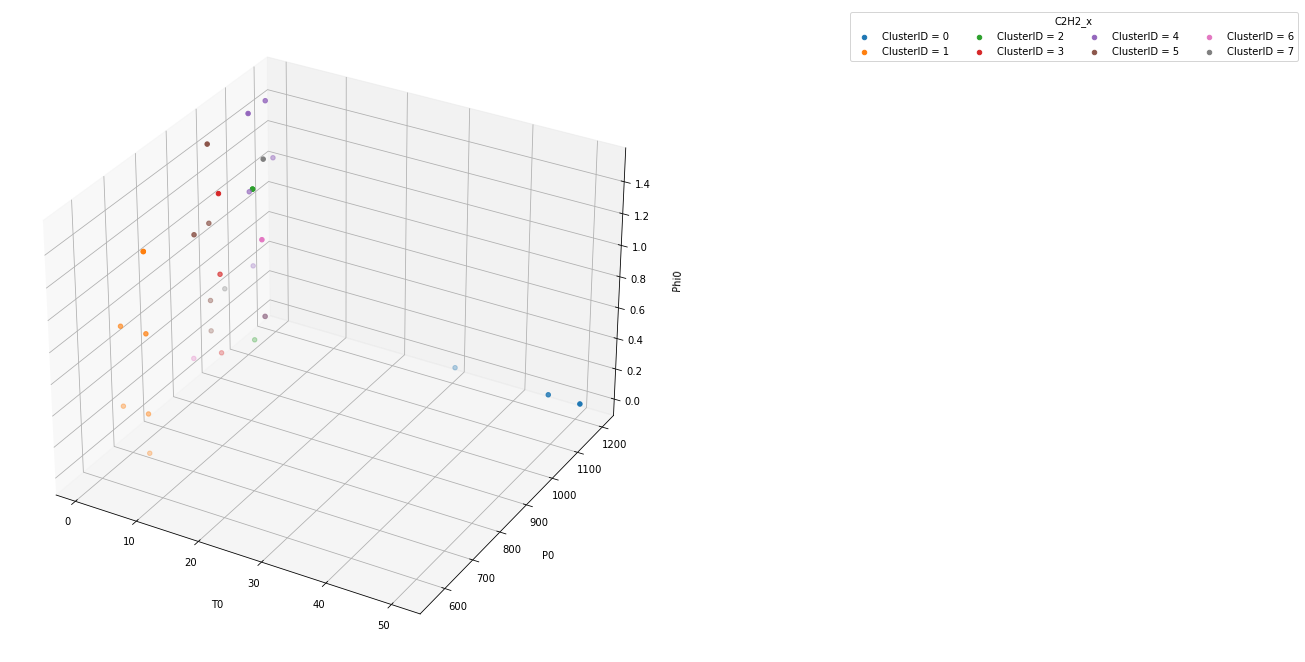

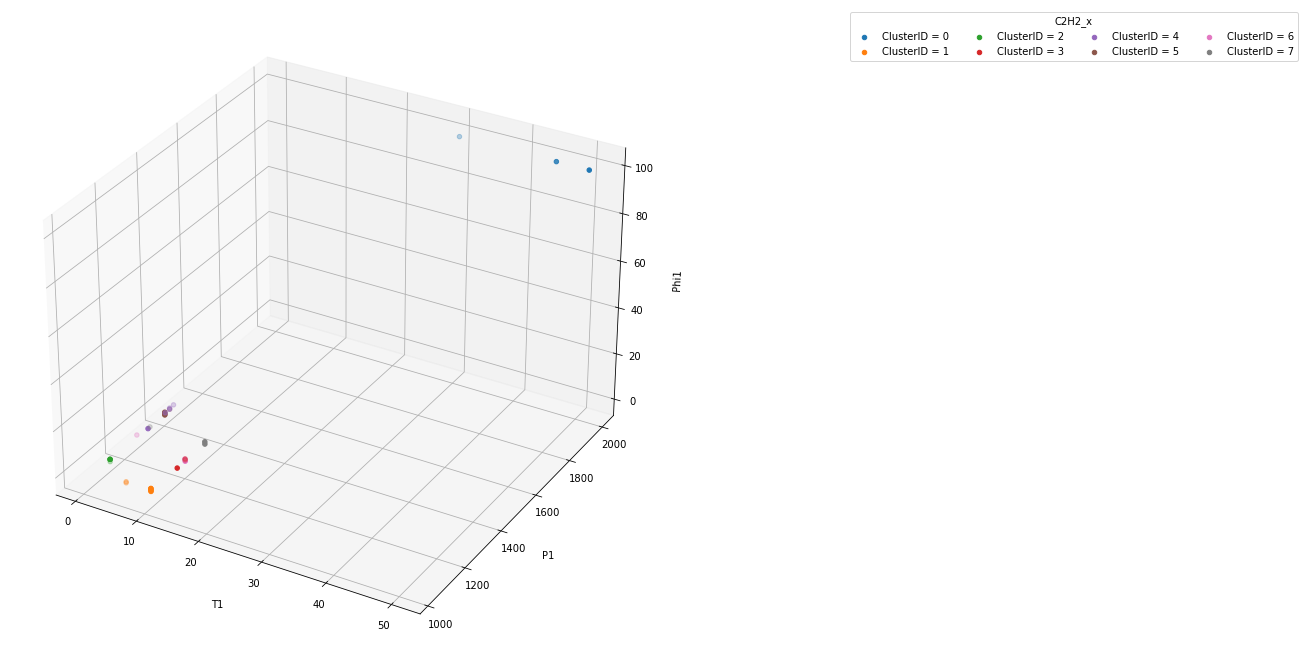

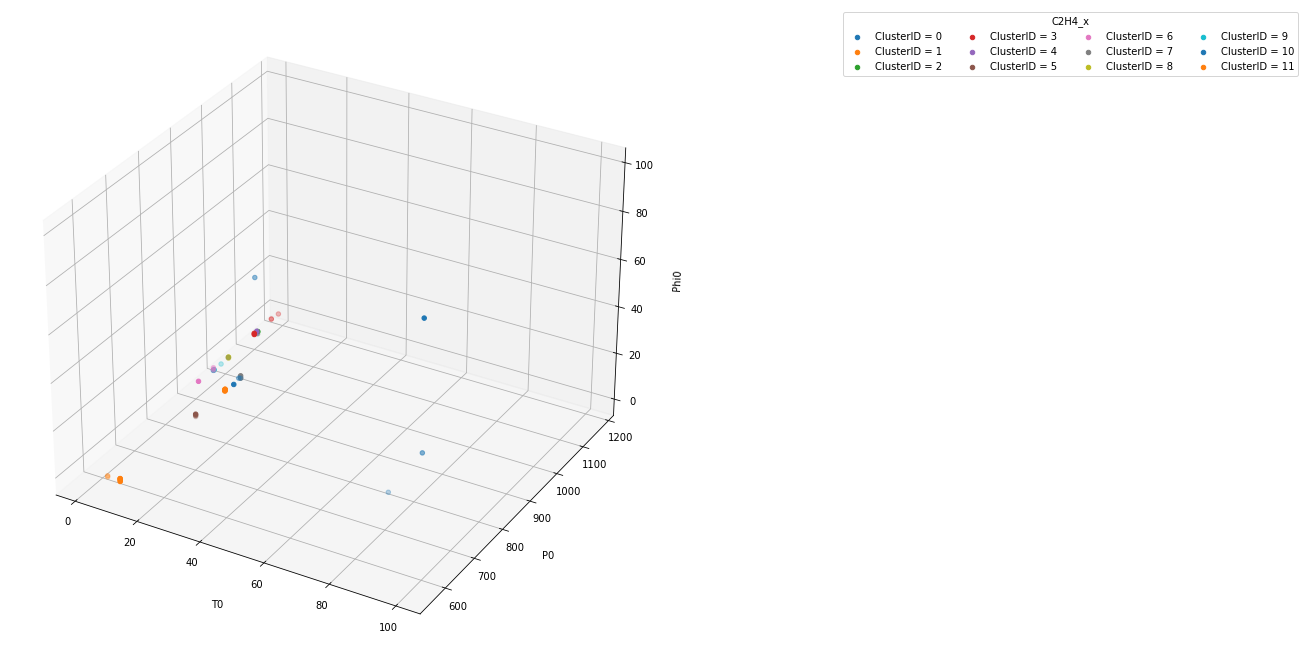

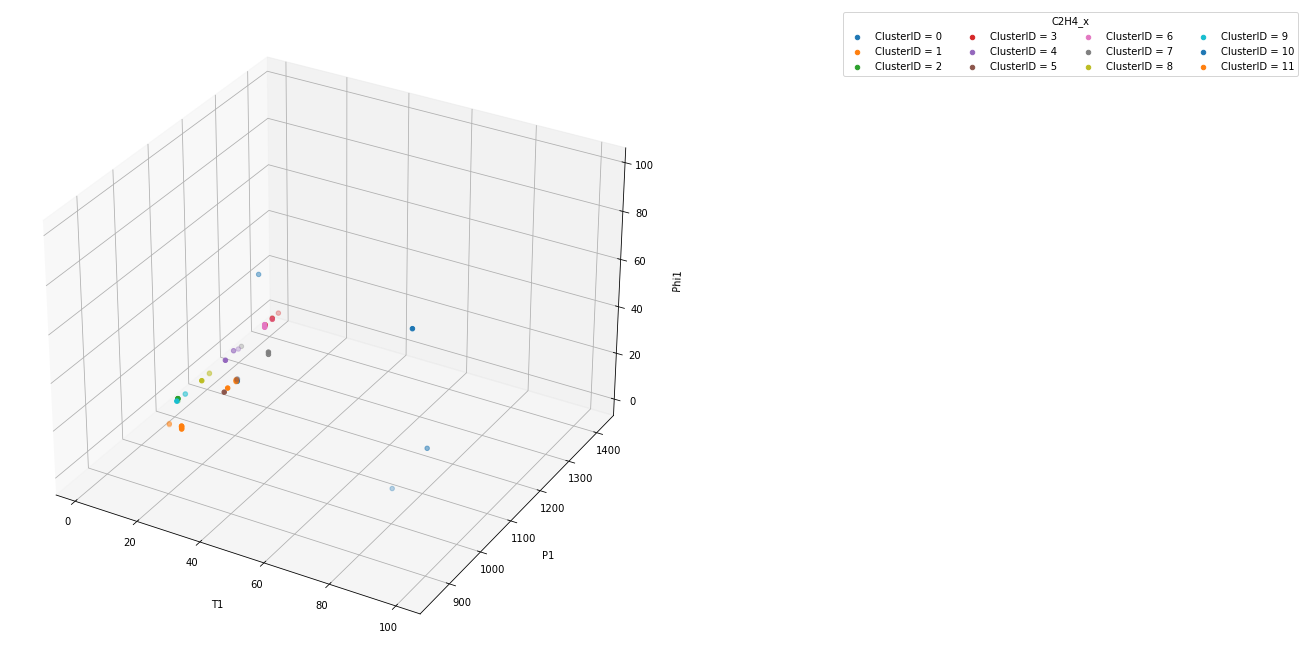

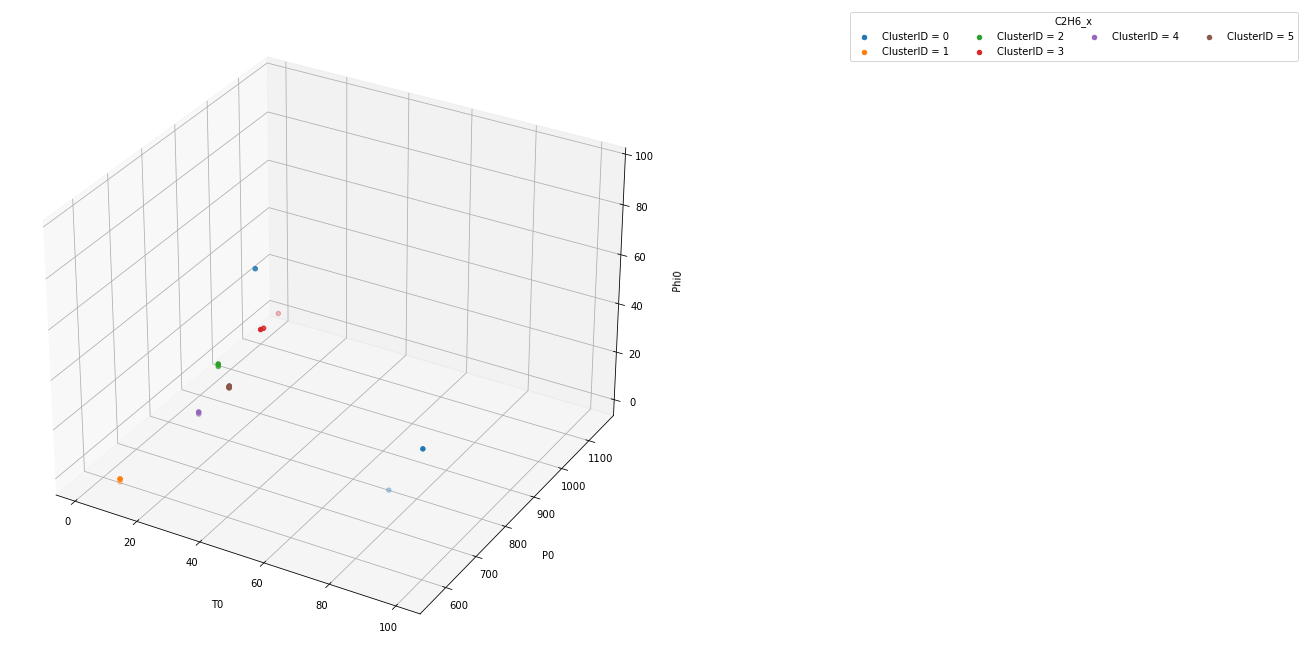

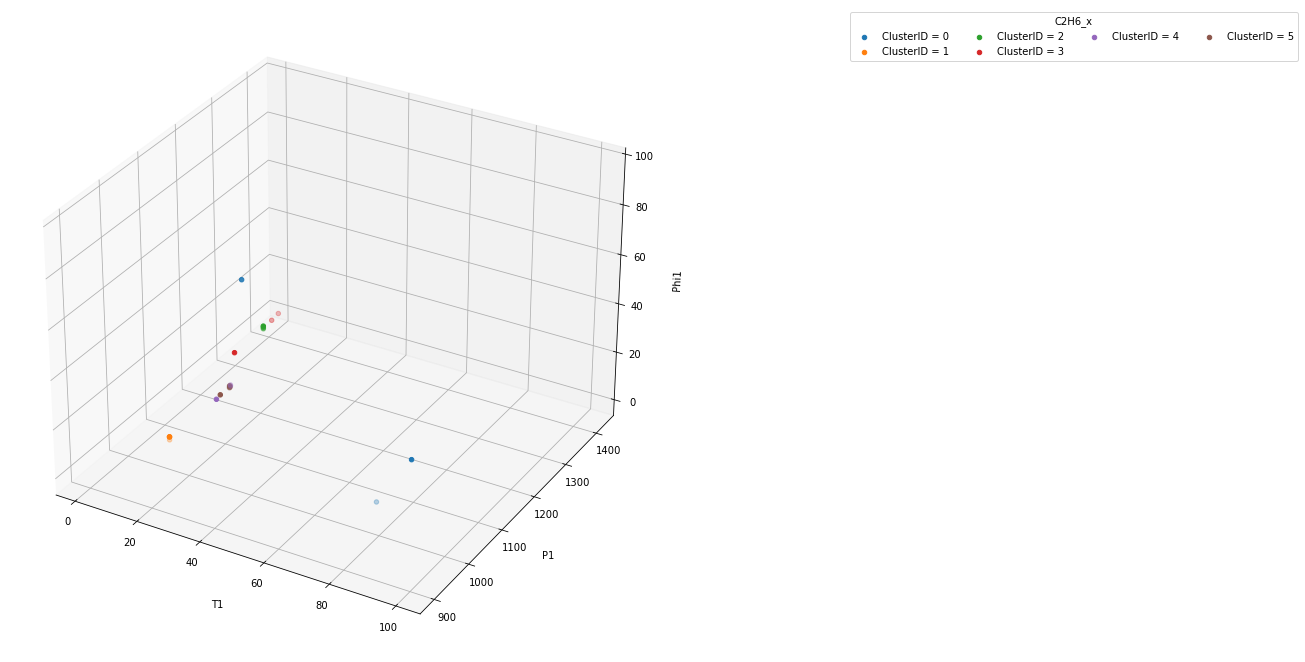

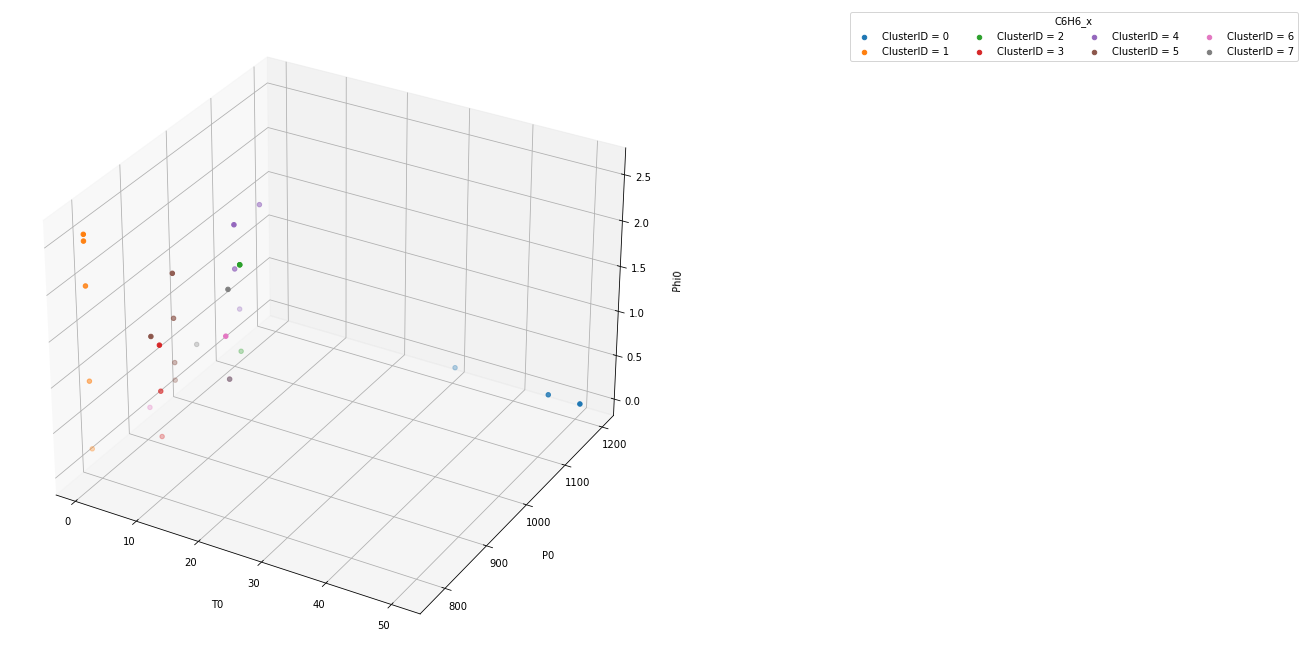

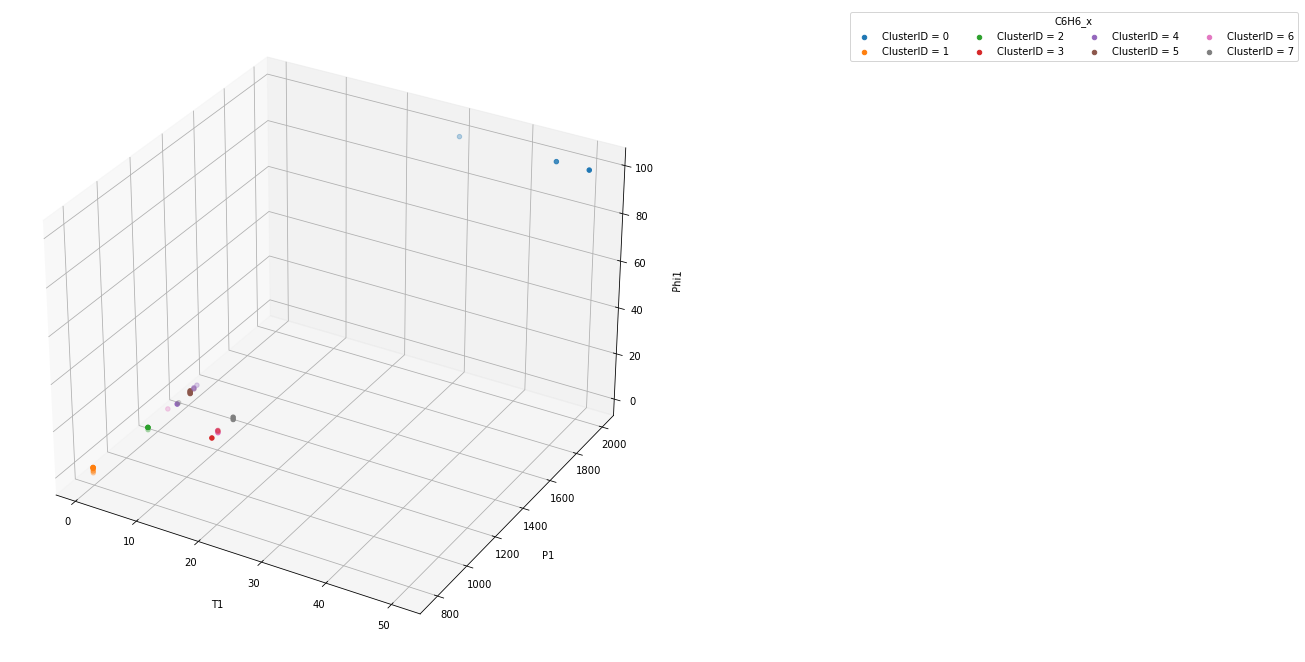

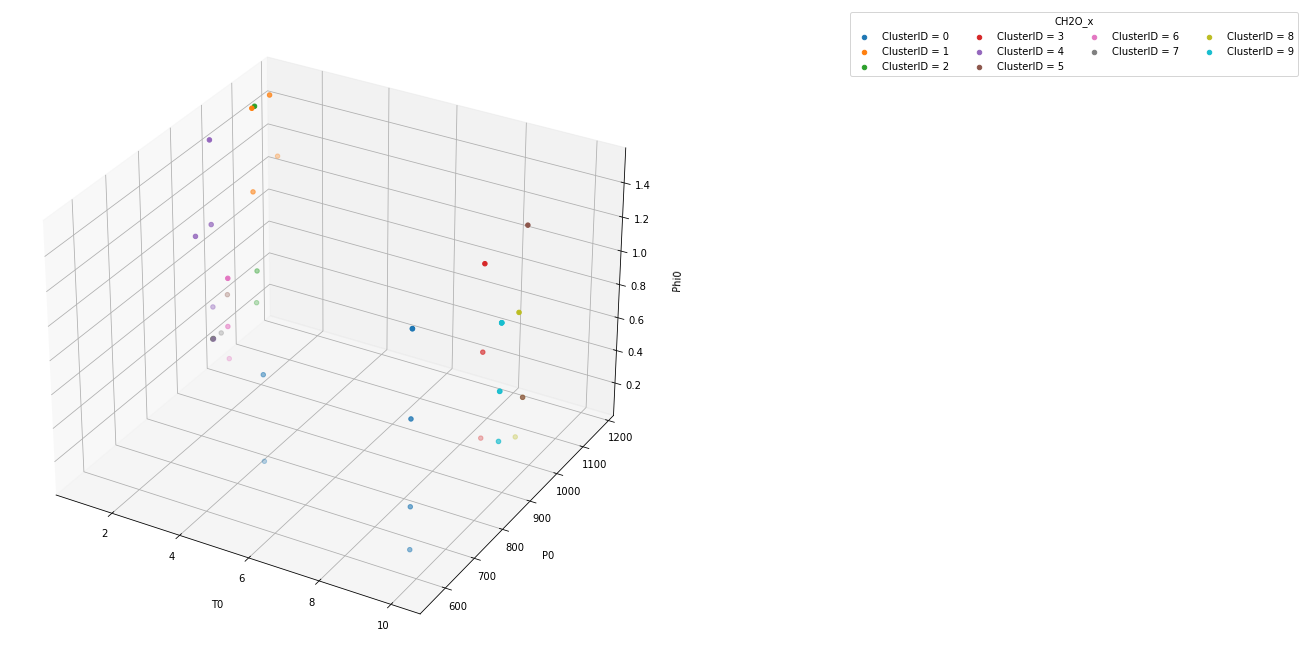

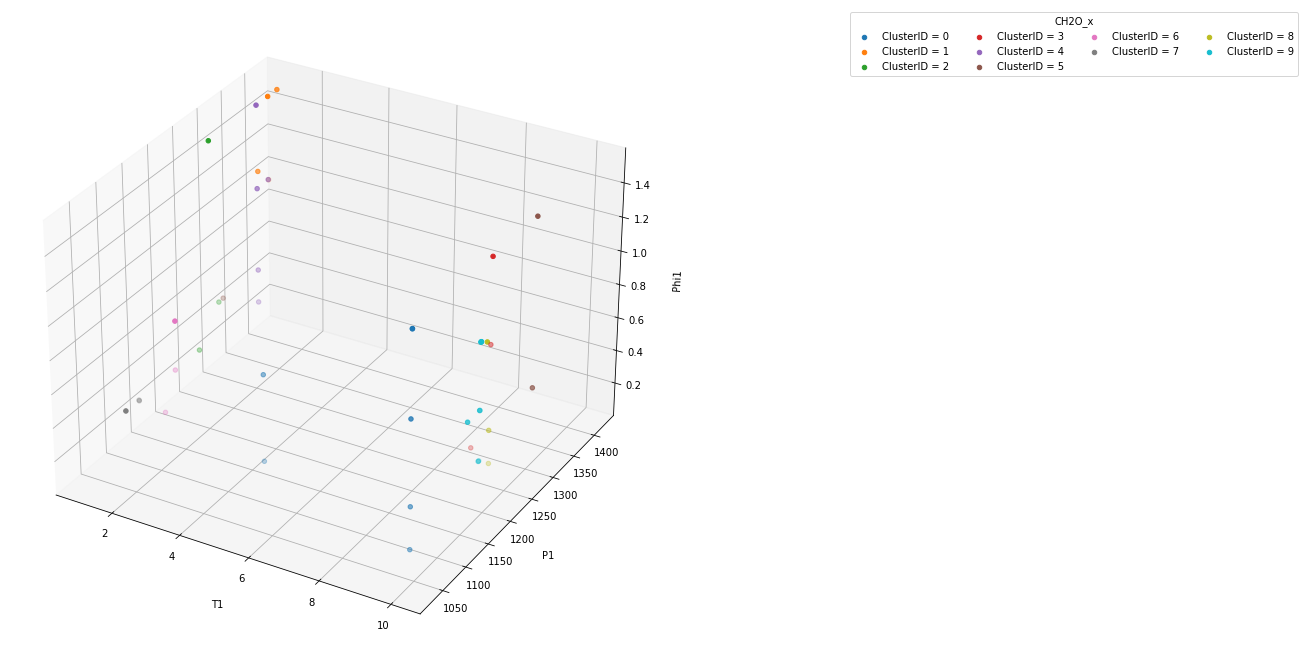

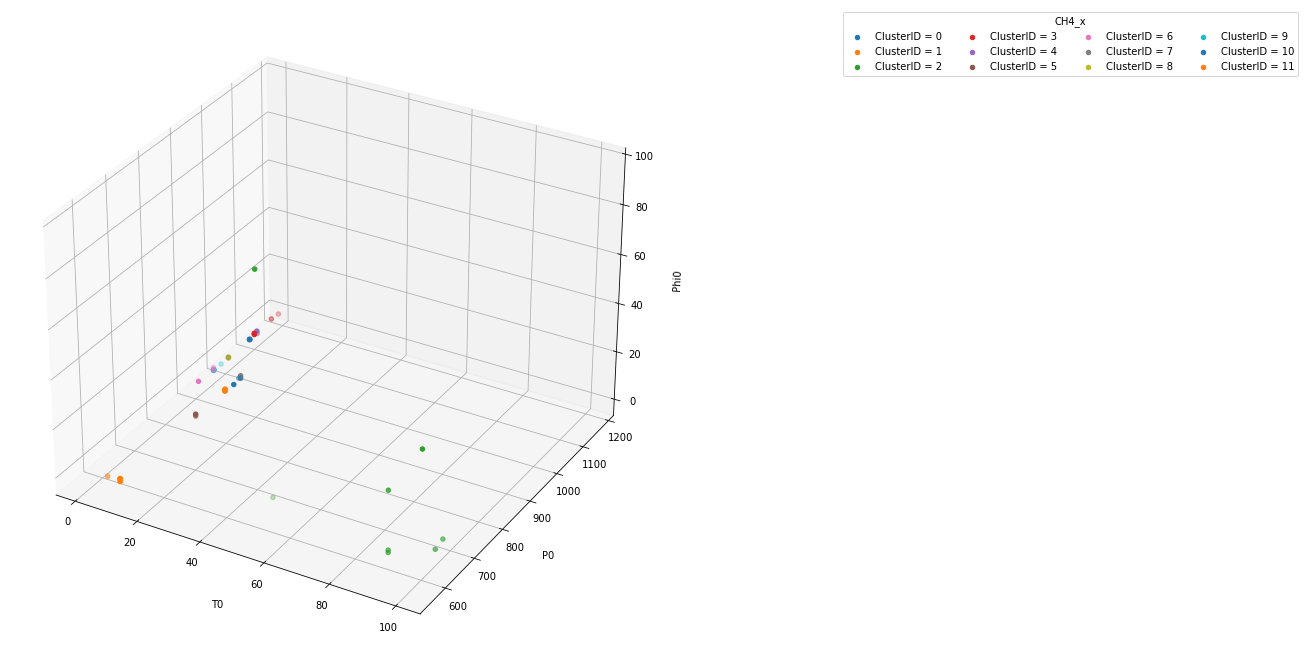

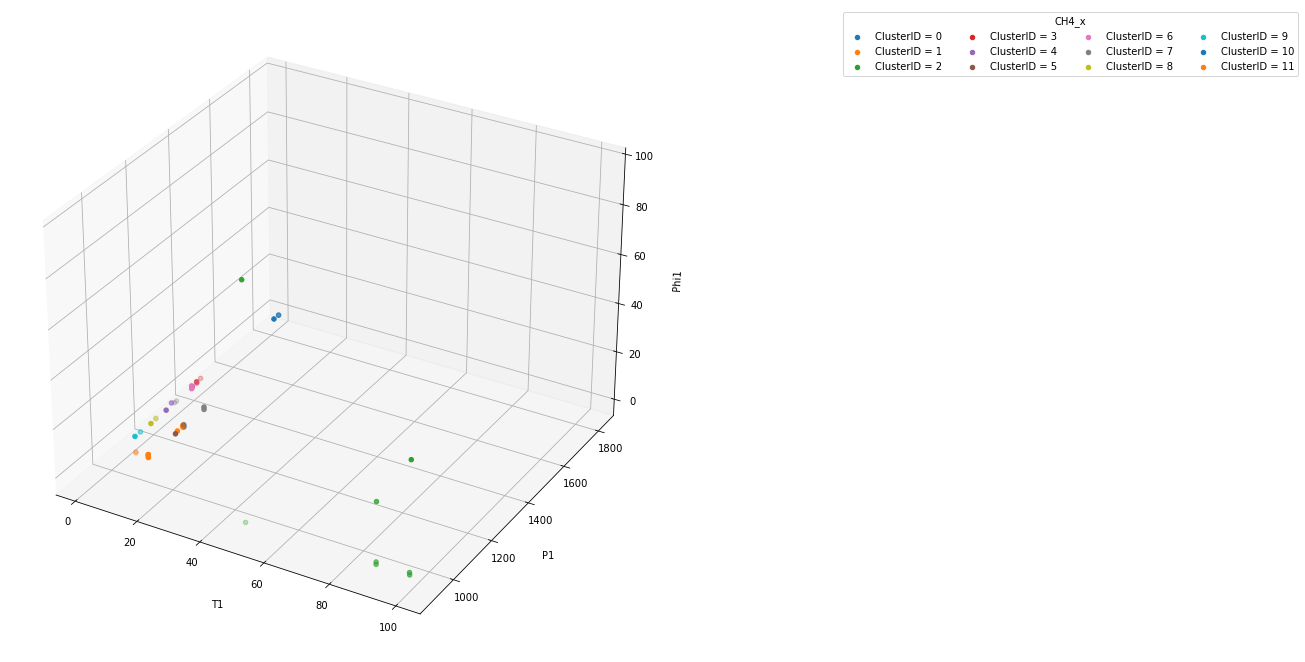

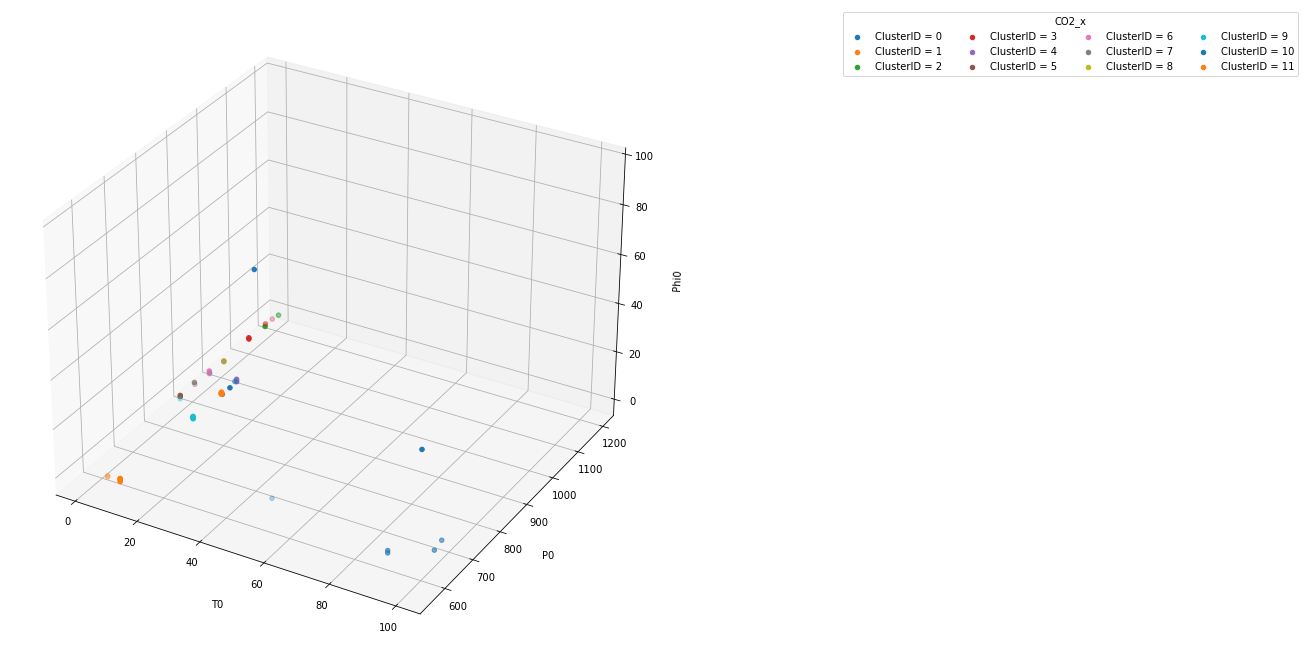

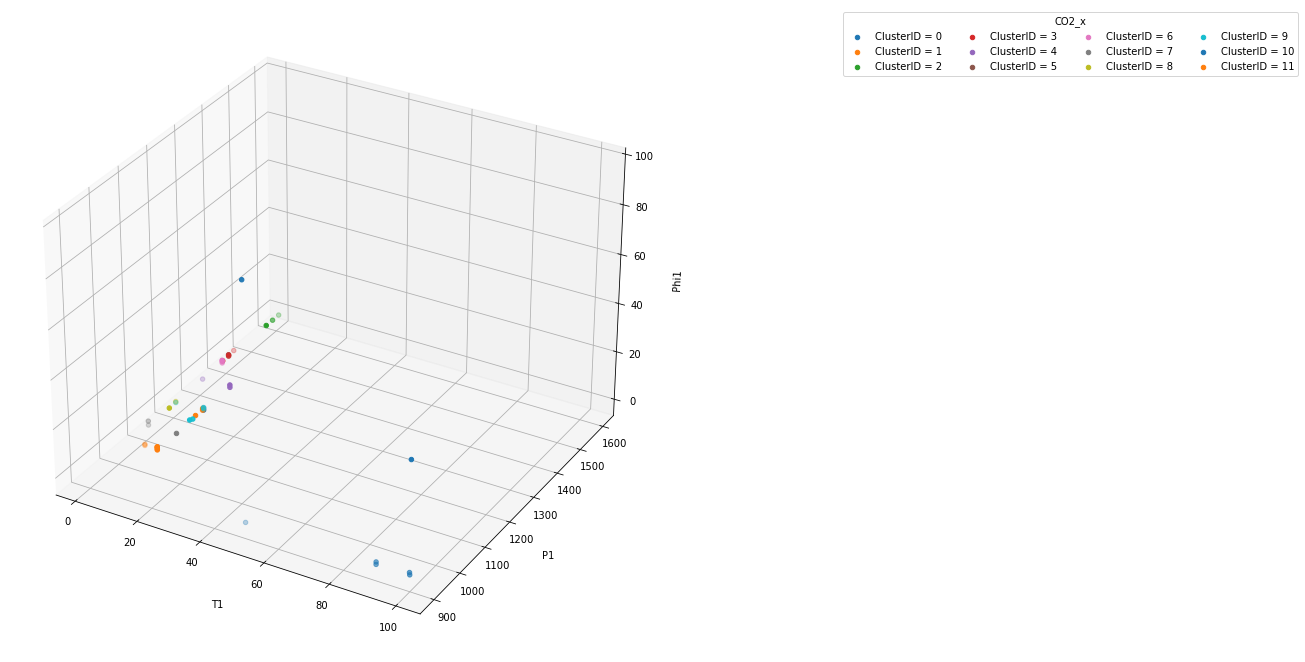

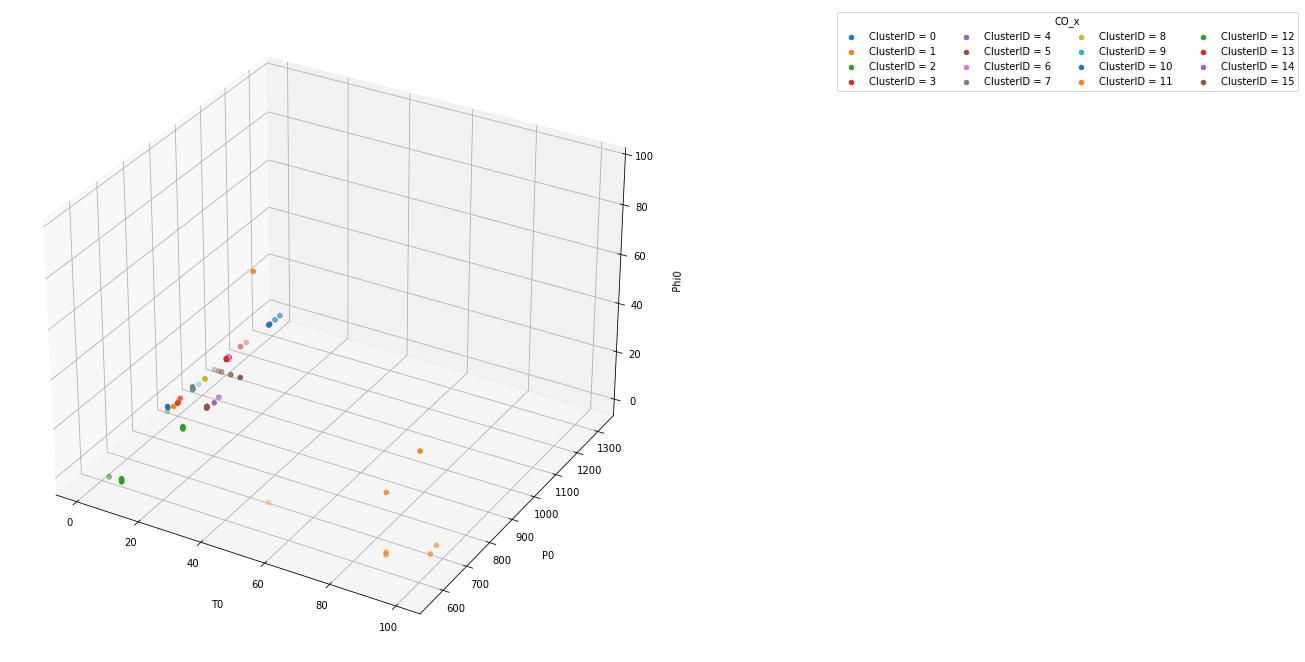

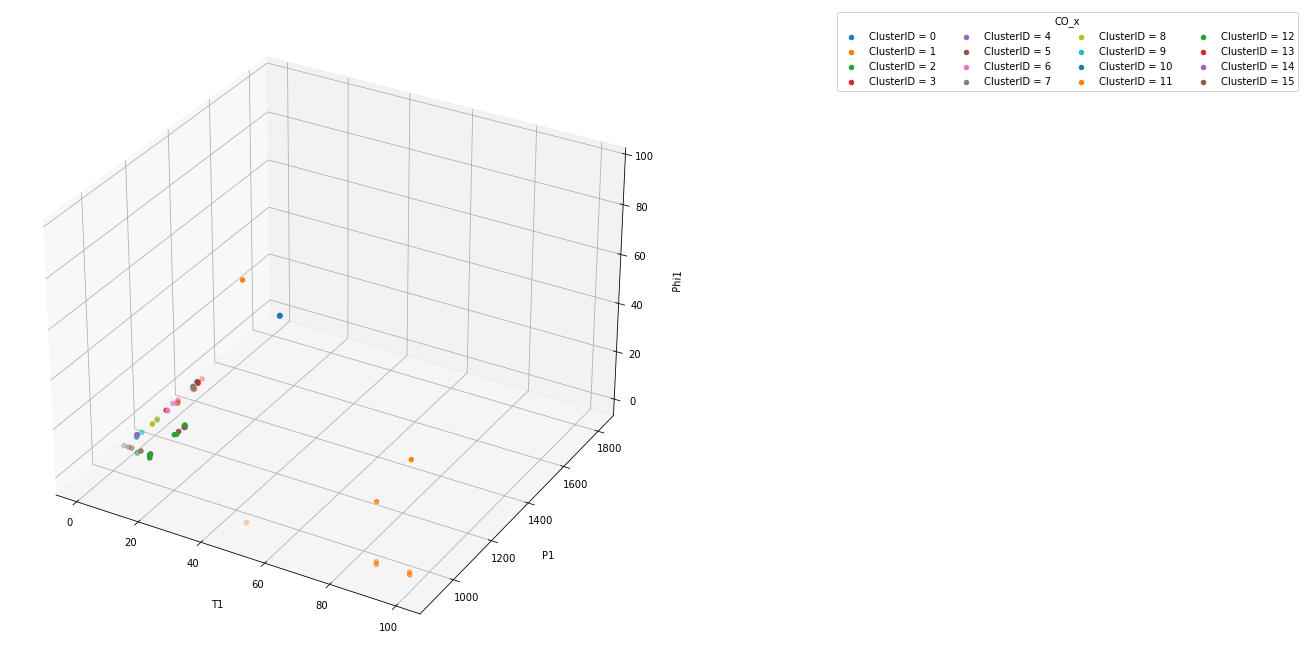

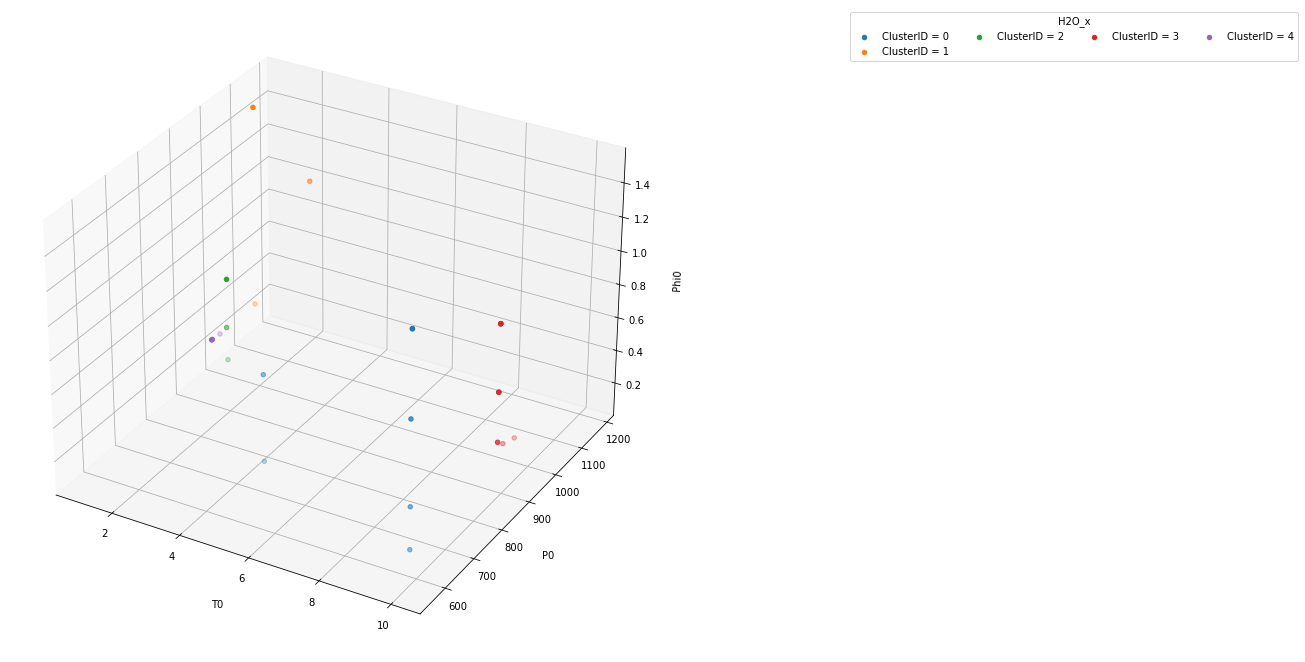

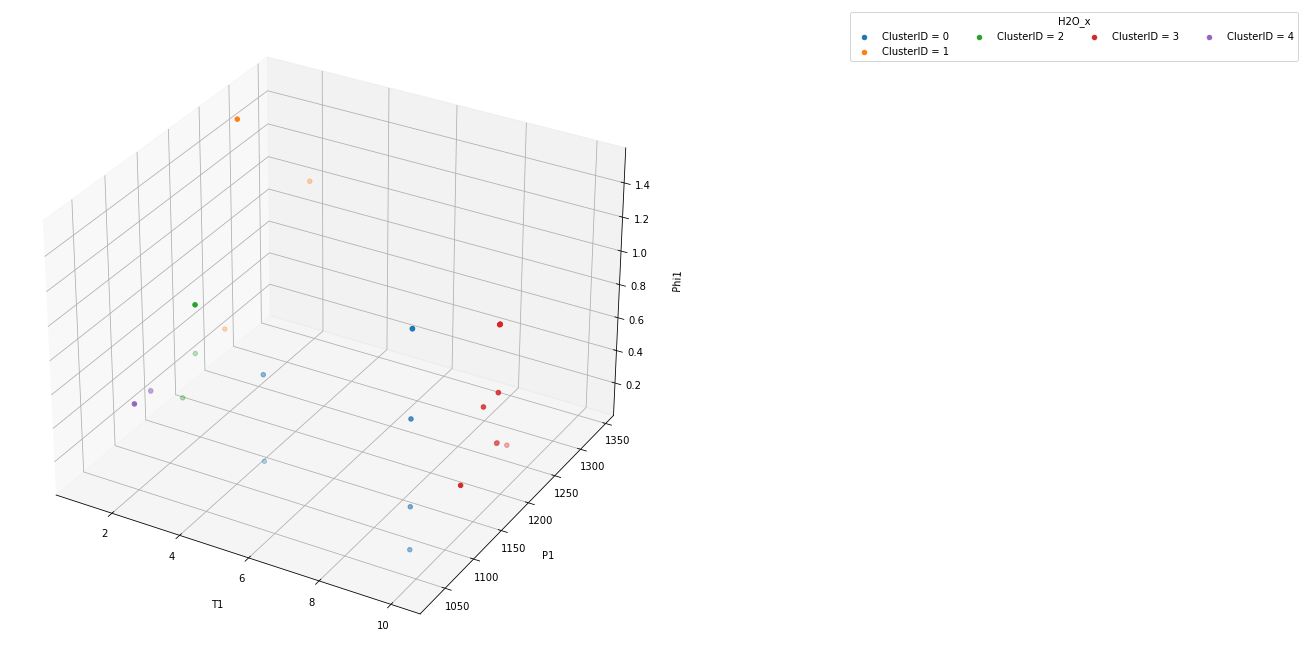

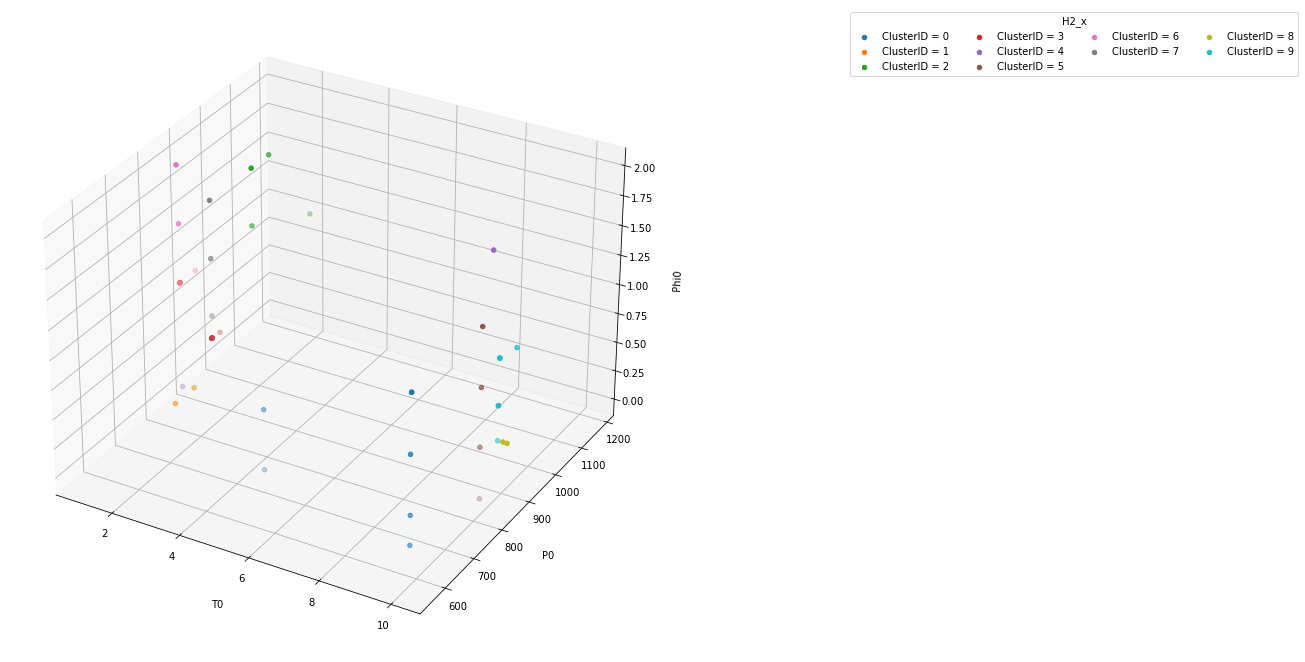

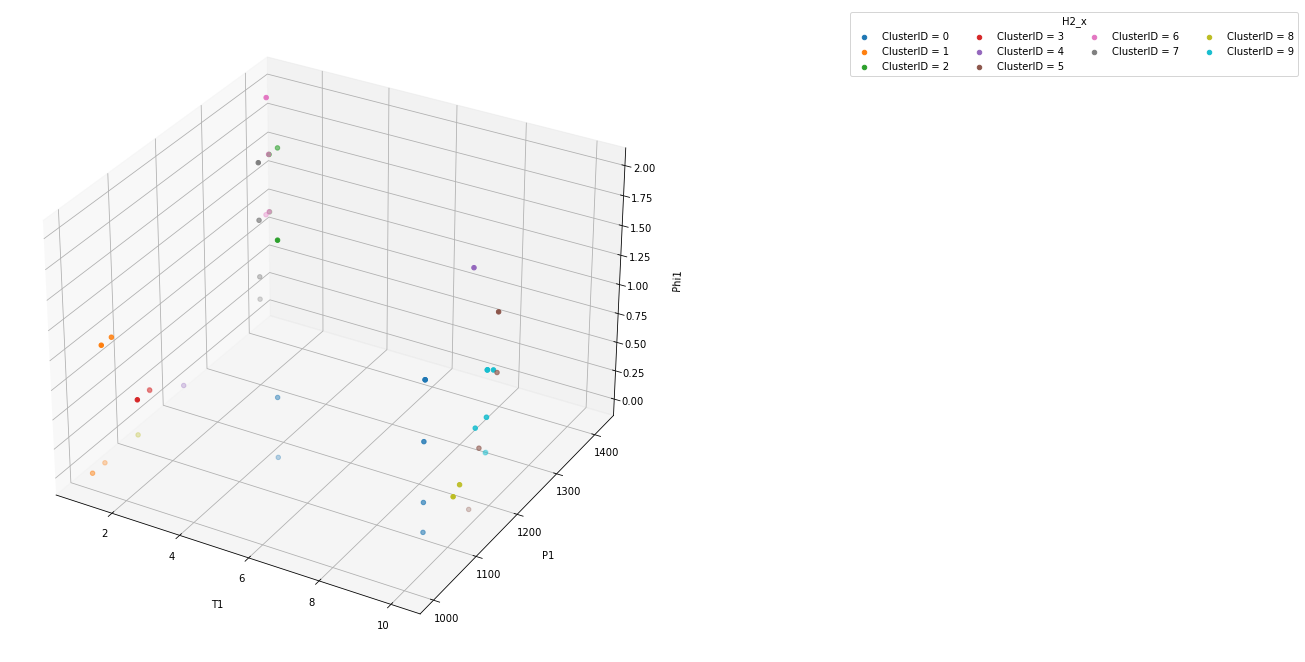

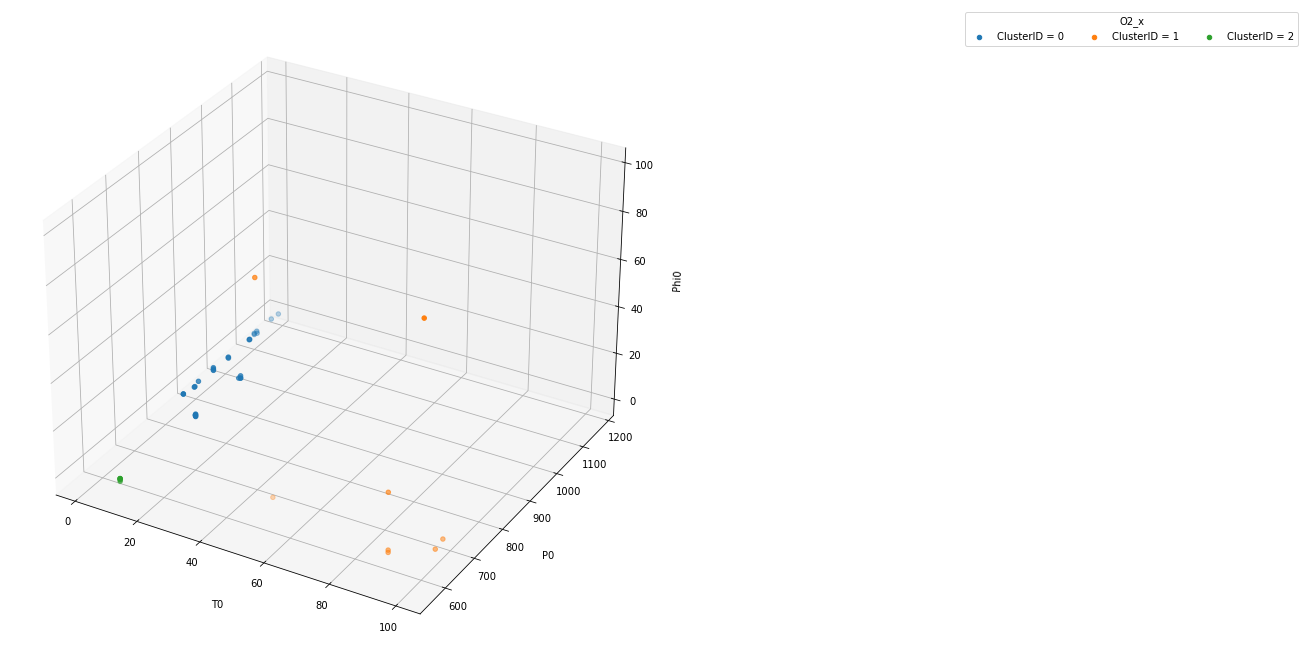

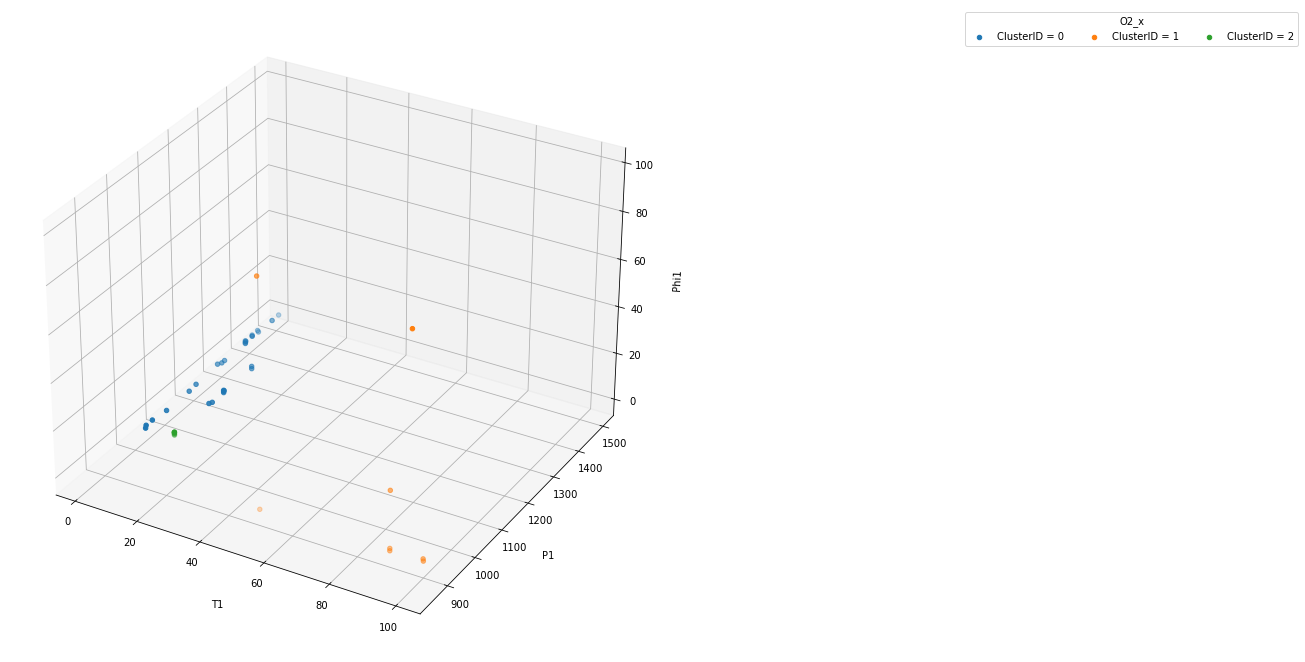

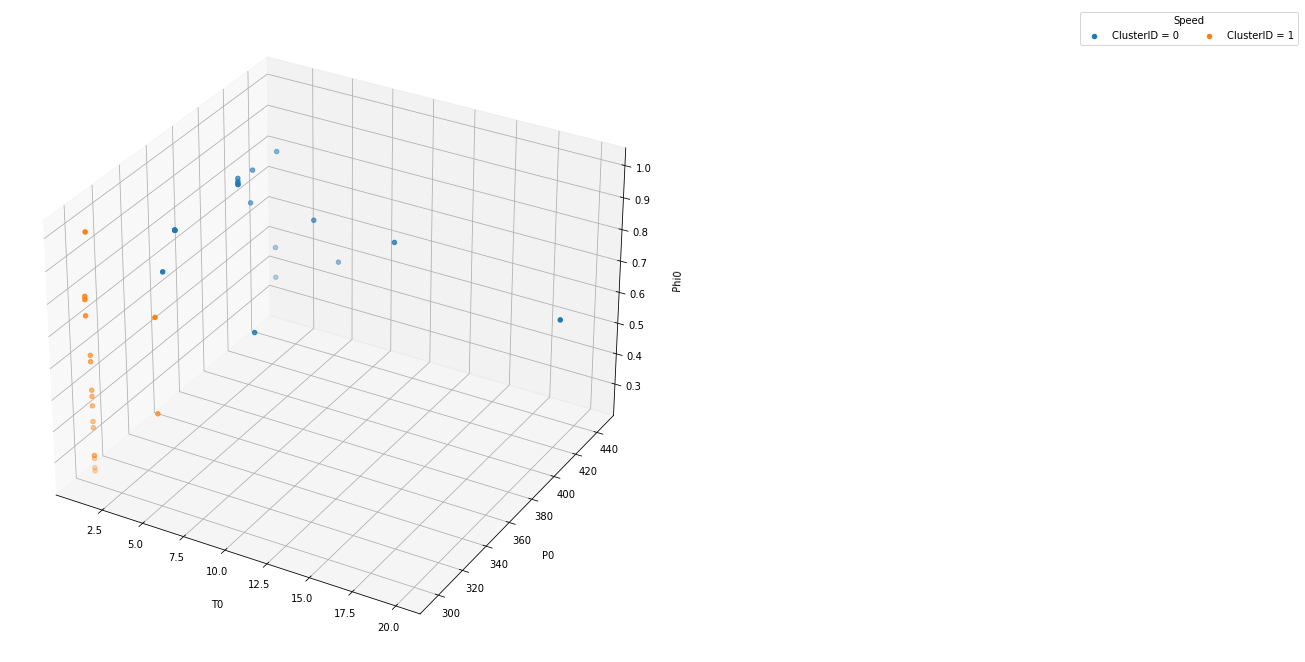

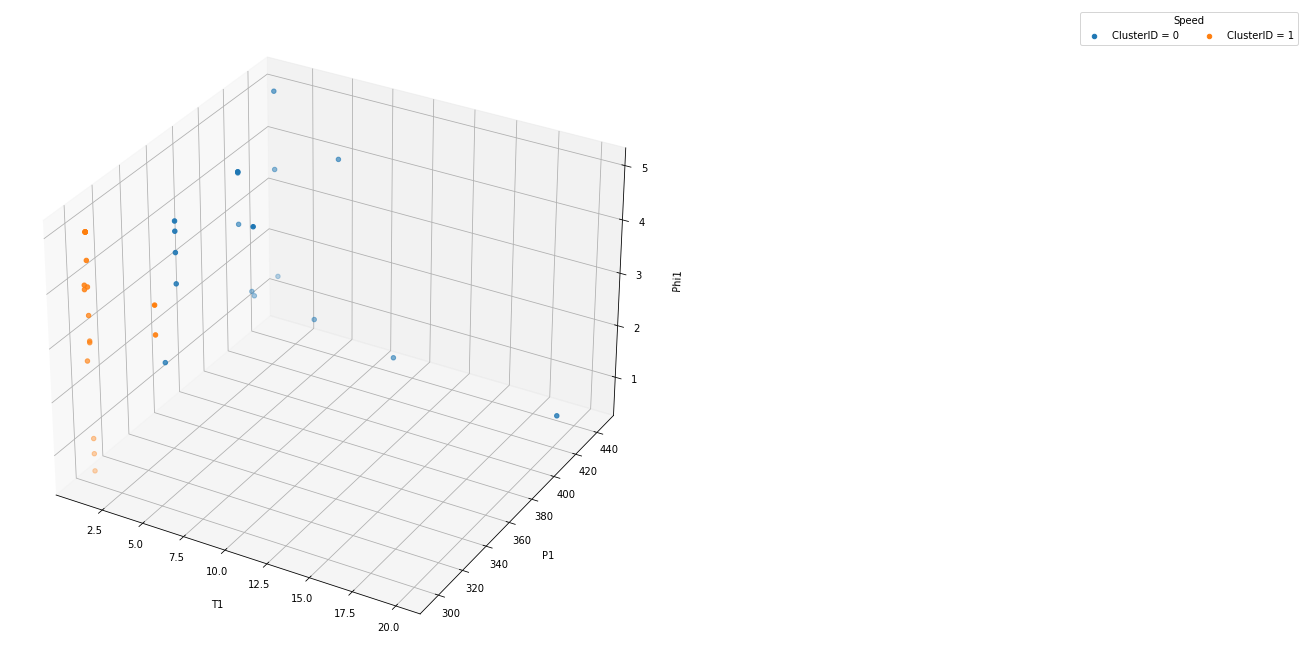

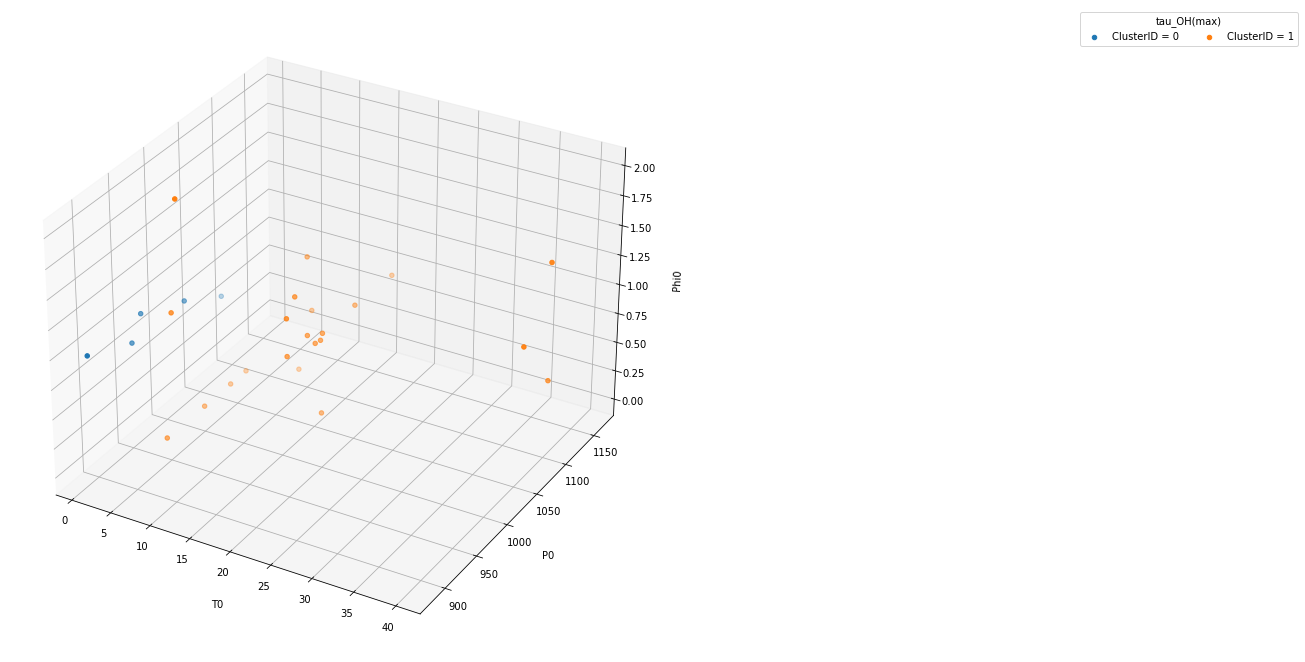

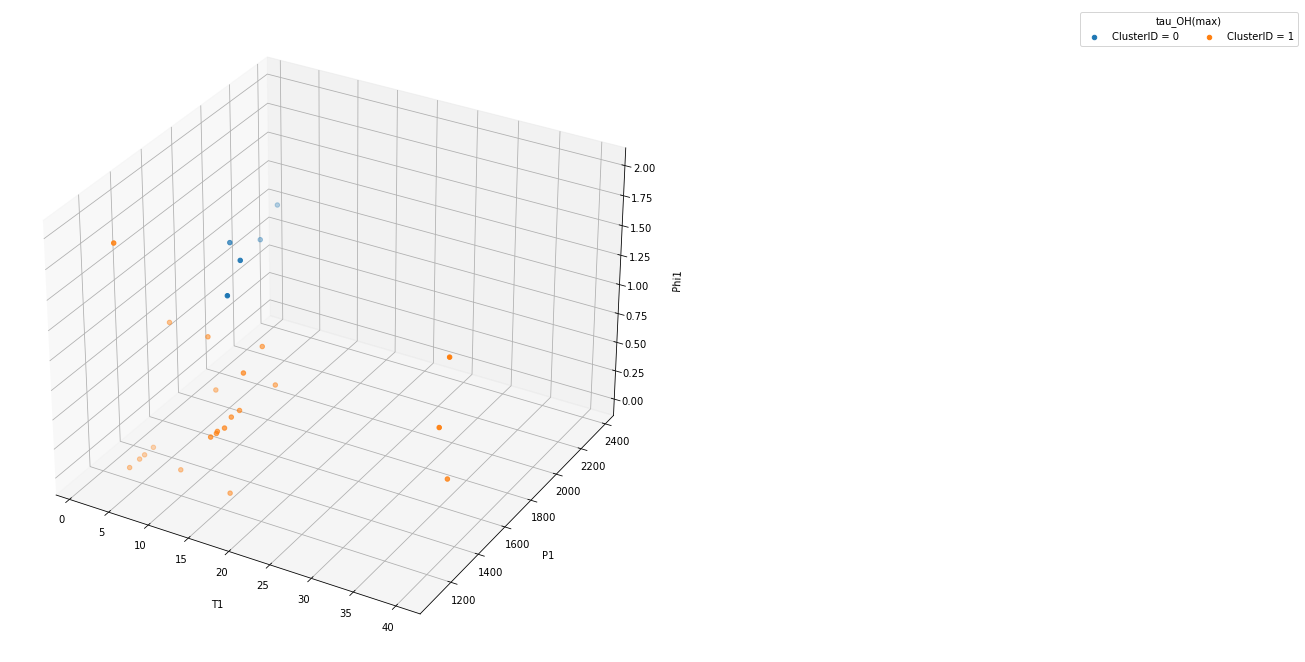

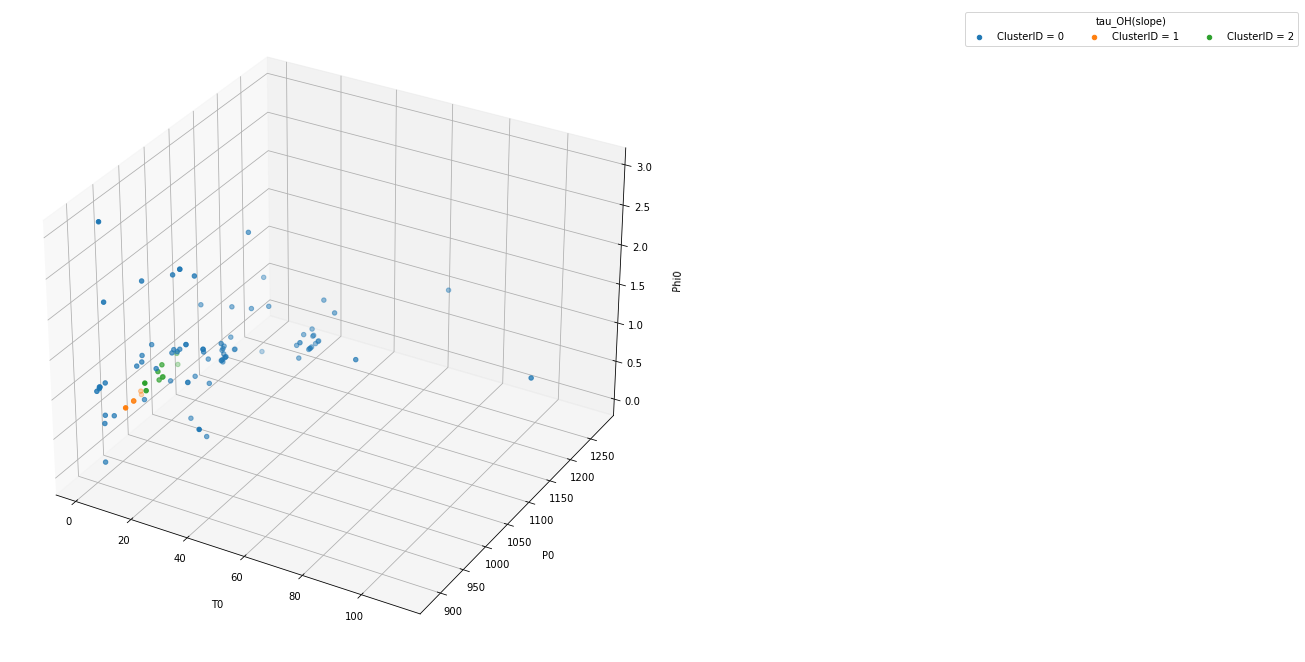

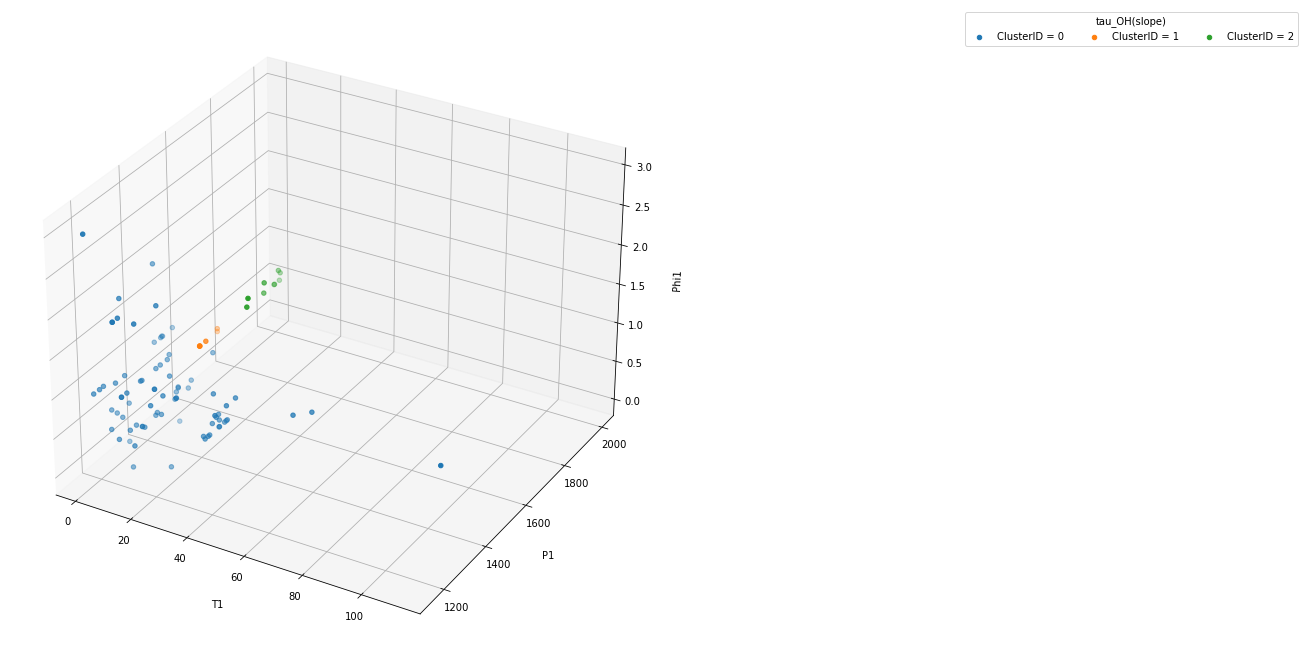

In [192]:
def graph_the_groups(groups):
    for group in groups:
        for i in [['T0','P0', 'Phi0'],['T1','P1', 'Phi1']]:
            graph_the_data_by_cluster(group[1], i, ignore_noise=True, title = group[0])
graph_the_groups(clustered_groups)